In [4]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
# import swifter
from scipy import stats
%matplotlib inline

- Ставим гипотезу
- Выбираем метрику
- Разбиваем на группы
- Запускаем АА
- Запускаем АВ
- Проверяем результаты

### Система сплитования

In [1]:
def ab_split(id, salt='exp_mess_1', n_groups=5):
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

In [5]:
connection = {
    'host': 'https://clickhouse...',
    'password': '',
    'user': '',
    'database': 'simulator_20220420'
}

In [11]:
q = """
SELECT distinct user_id
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-04-15' and toDate(time) <= '2022-04-21' 
"""

In [12]:
# Вытащили пользователей
users_df = pandahouse.read_clickhouse(q, connection=connection)

In [13]:
users_df.head()

,user_id
0,33099
1,39117
2,39309
3,117248
4,128232


In [16]:
len(users_df)

65023

In [14]:
# Сделали группы
users_df['hash_group'] = users_df['user_id'].apply(ab_split)

In [21]:
# Смотрим на число пользователей в каждой группе
users_df.groupby('hash_group').nunique().reset_index()

,hash_group,user_id
0,0,13173
1,1,13084
2,2,12805
3,3,12921
4,4,13040


#### В кликхаусе

In [23]:
q = """
SELECT xxHash64(toString(user_id)||'my_salt')%5 as group, 
    uniqExact(user_id)
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-04-15' and toDate(time) <= '2022-04-21' 
group by group 
"""

pandahouse.read_clickhouse(q, connection=connection)

,group,uniqExact(user_id)
0,0,13092
1,1,12920
2,2,12999
3,3,13168
4,4,12844


### Проверка корректности работы системы сплитования. AA-тест

АА-тест проходил с '2022-03-28' по '2022-04-03'  

In [51]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-03-28' and '2022-04-03'
    and exp_group in (2, 3)
GROUP BY exp_group, user_id
"""

In [52]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [29]:
df.groupby('exp_group').count()[['user_id']]

,user_id
exp_group,
2,8480
3,8569


In [9]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7, 8.27)})

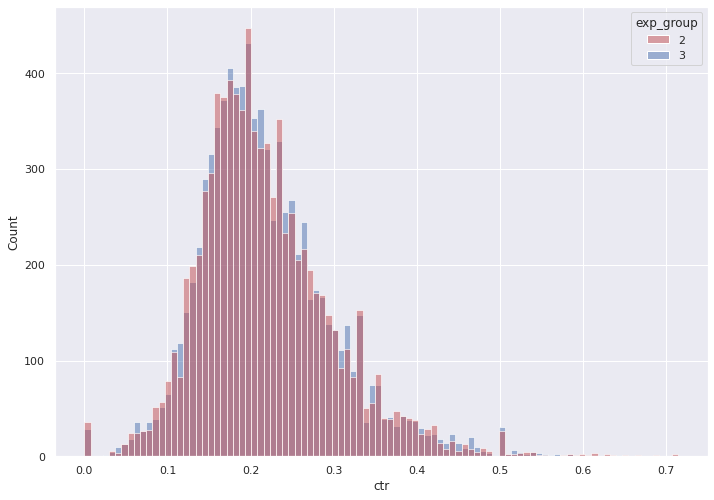

In [30]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Выглядит одинаково

#### Проверим тестами

##### Тест Стьюдента

<div>
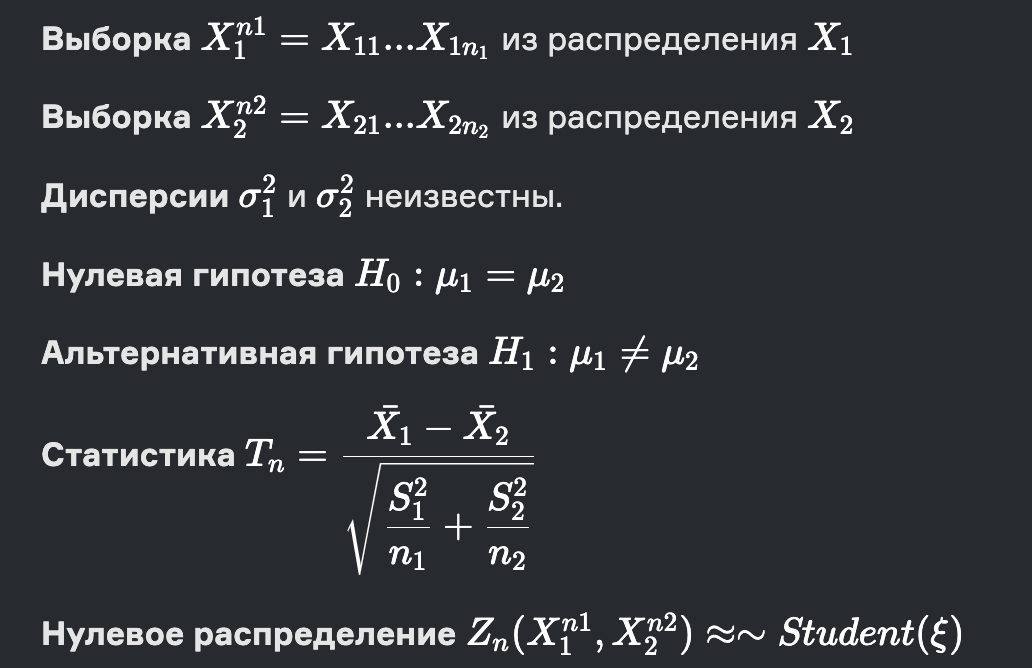
</div>

Не работает, если:

- Распределение очень сильно скошено.
- В распределении много выбросов.
- В распределении очень высока вероятность больших по модулю отклонений (жирные выбросы — часть распределения).

Главная проблема — t-тест требует явной оценки дисперсии исследуемой метрики (которая в знаменателе), а построить ее не всегда получается, например, если вы исследуете значение квантиля некоторого неизвестного заранее распределения.

In [33]:
stats.ttest_ind(df[df['exp_group'] == 2]['ctr'],
                df[df['exp_group'] == 3]['ctr'],
                equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

Тест показал, что различий нет.

##### Тест Манна-Уитни

<div>
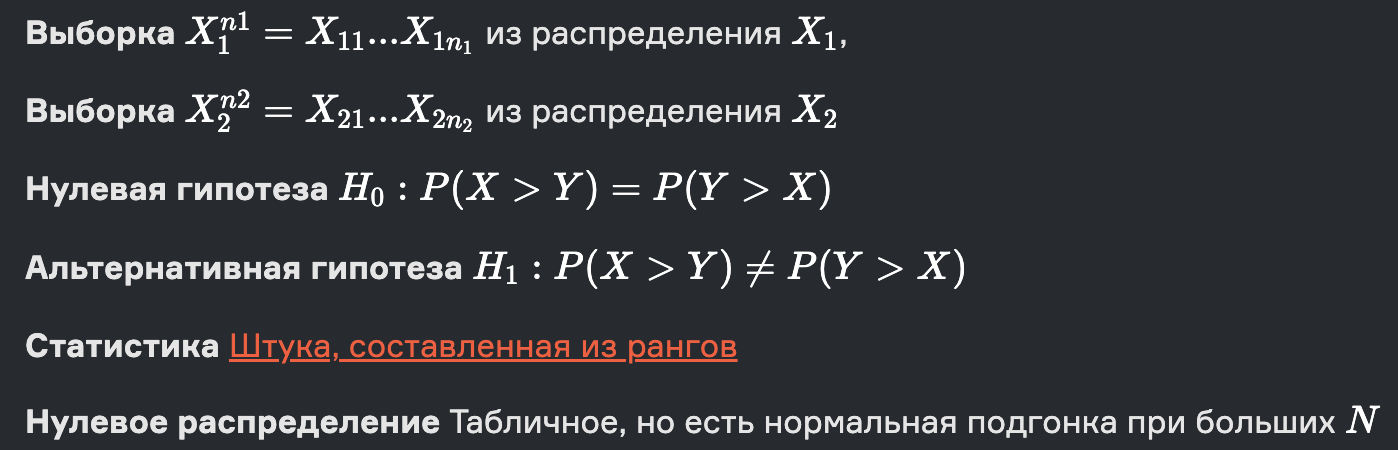
</div>

In [53]:
stats.mannwhitneyu(df[df['exp_group'] == 2]['ctr'],
                   df[df['exp_group'] == 3]['ctr'],
                   alternative='two-sided')

MannwhitneyuResult(statistic=36124728.5, pvalue=0.5177480614337441)

Тест показал, что различий нет.

In [39]:
# Покажем значение нулевой гипотезы: если из выборки Х и Y выбирать по числы и сравнивать их, 
# то равновероятно одно может показаться больше другого.
# и если выбирать числа из одной выборки, то это условие выполняется

A_gt_B = 0
for _ in range(10000):
    A_gt_B += df[df['exp_group'] == 2]['ctr'].sample().values[0] > df[df['exp_group']== 3]['ctr'].sample().values[0]
    
print('В', A_gt_B / 100, '% случаев A > B. Должно получиться около 50%')

В 50.18 % случаев A > B. Должно получиться около 50%


### AB-тест

AB проходил с 2022-04-04 по 2022-04-10 включительно    

Тестовые группы:
* exp_group = 0 – Все по-старому
* exp_group = 3 - Рекомендации "постов, которые лайкали похожие на вас люди"

In [54]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
    and exp_group in (0, 3)
GROUP BY exp_group, user_id
"""

In [55]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [44]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545


In [47]:
#T-тест
stats.ttest_ind(df[df['exp_group'] == 0]['ctr'],
                df[df['exp_group'] == 3]['ctr'],
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

Тест показал, что есть различия

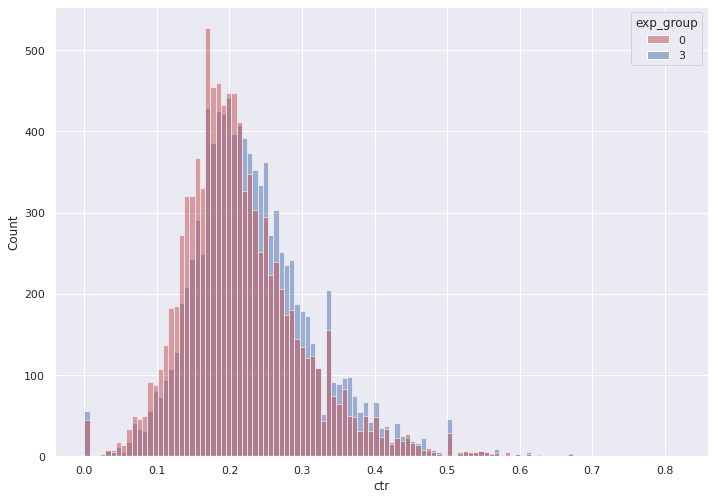

In [46]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Визуально видим сдвиг

In [49]:
# Проверим тестом М-В
stats.mannwhitneyu(df[df['exp_group'] == 0]['ctr'],
                   df[df['exp_group'] == 3]['ctr'],
                   alternative='two-sided')

MannwhitneyuResult(statistic=43682792.0, pvalue=1.1952055473582936e-57)

Этот тест тоже показал различия

#### Можно проверить в кликхаусе

In [56]:
# t-тест

q = """WITH welchTTest(ctr, exp_index) as ttest

select tupleElement(ttest,1) as statistic,
    tupleElement(ttest,2) as p_value
FROM (SELECT exp_group, 
        case when exp_group = 0 then 0 else 1 end as exp_index,
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-04-04' and '2022-04-10'
        and exp_group in (0, 3)
    GROUP BY exp_group, user_id)
"""

In [57]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [58]:
df

,statistic,p_value
0,-13.896871,1.055849e-43


In [59]:
# тест Манна-Уитни

q = """WITH mannWhitneyUTest('two-sided')(ctr, exp_index) as mw

select tupleElement(mw,1) as statistic,
    tupleElement(mw,2) as p_value
FROM (SELECT exp_group, 
        case when exp_group = 0 then 0 else 1 end as exp_index,
        user_id, 
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-04-04' and '2022-04-10'
        and exp_group in (0, 3)
    GROUP BY exp_group, user_id)
"""

In [60]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [61]:
df

,statistic,p_value
0,43628426.5,1.685319e-13


### Сглаженный CTR. Сглаживание Лапласа
https://en.wikipedia.org/wiki/Sunrise_problem

In [1]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [2]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes / views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
    and exp_group in (0, 3)
GROUP BY exp_group, user_id
"""

In [6]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [7]:
global_ctr_1 = df[df['exp_group'] == 0]['likes'].sum() / df[df['exp_group'] == 0]['views'].sum()
global_ctr_2 = df[df['exp_group'] == 3]['likes'].sum() / df[df['exp_group'] == 3]['views'].sum()

In [15]:
group1 = df[df['exp_group'] == 0].copy()

In [16]:
# сглаженный CTR
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

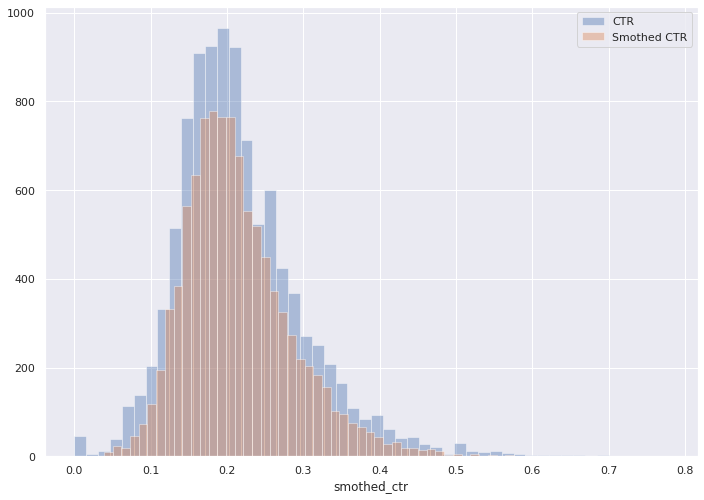

In [28]:
sns.distplot(group1['ctr'], kde = False, label='CTR')
sns.distplot(group1['smothed_ctr'], kde = False, label='Smothed CTR')
plt.legend()

### Бутстреп

#### Непараметрический бутстреп
У нас есть выборка из группы А (все по-старому) и выборка из группы В (выборка с новой системой рекомендаций). Нагенерируем из каждой из этих выборок псевдовыборки с возвращением.

In [29]:
# Есть выборка
df = pd.DataFrame()
df['data'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [34]:
# генерю псевдовыборку
[np.random.choice(df['data']) for _ in range(len(df))]

[6, 10, 5, 8, 8, 5, 4, 3, 7, 3]

In [35]:
# То же самое на pandas 
df['data'].sample(10, replace=True).tolist()

[9, 6, 1, 3, 3, 3, 7, 7, 3, 8]

#### Биномиальный бутстрап
А можно по-другому. Мы можем считать «сколько раз в псевдовыборку попадет наше наблюдение». Такая величина будет иметь биномиальное распределение вида:

$k = Binomial(n, 1/n)$

In [36]:
df = pd.DataFrame()
df['data'] = np.random.randint(1, 100000, 10000)

<AxesSubplot:ylabel='Count'>

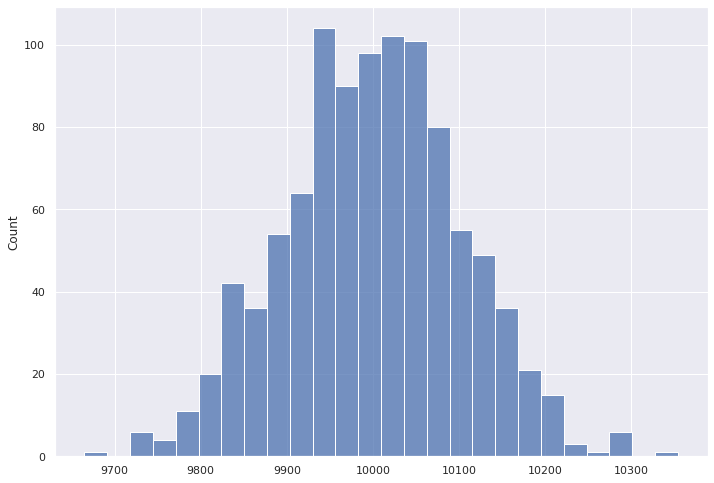

In [37]:
sample_length = 10000
p_to_be_taken = 1 / sample_length
number_of_samples = 1000

sums = [sum(stats.binom(sample_length, 
                        p_to_be_taken).rvs(sample_length)) for _ in range(number_of_samples)]

sns.histplot(sums)

#### Пуассоновский бутстреп
При большой длине выборки наше биномиальное распределение – почти то же самое, что распределение Пуассона:

$k = Binomial(n, 1/n) \sim Poisson(1)$

<div>
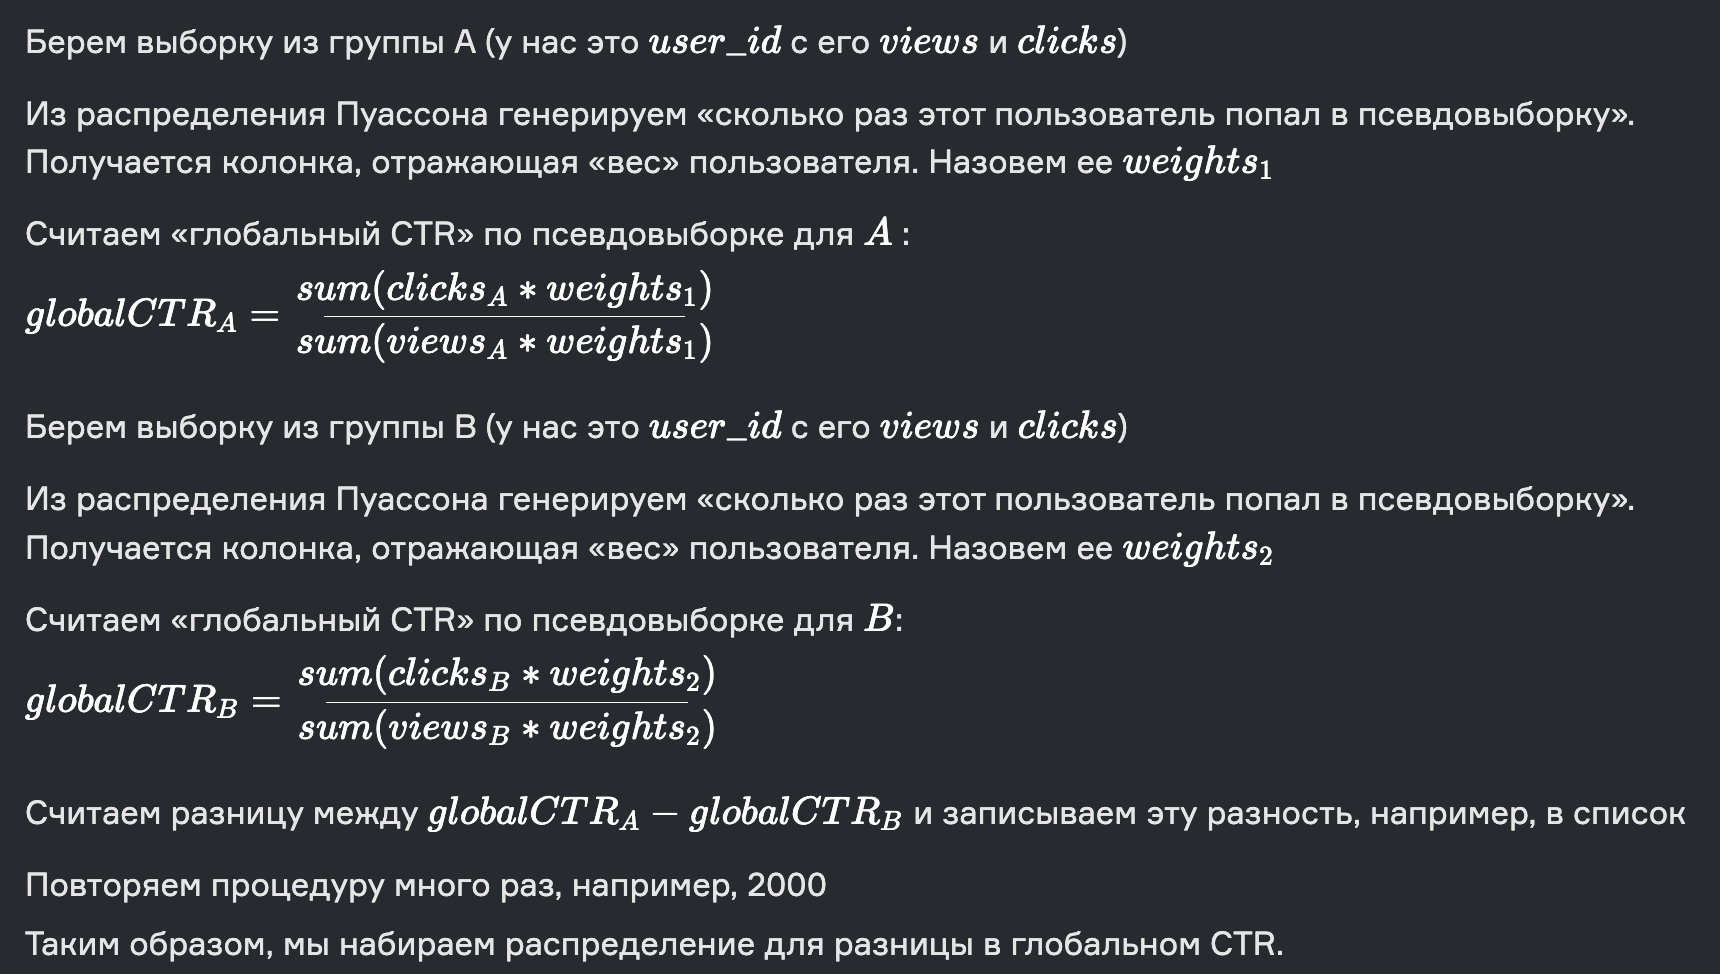
</div>

In [38]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [39]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
    and exp_group in (0, 3)
GROUP BY exp_group, user_id
"""


In [40]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [41]:
likes1 = df[df['exp_group'] == 0]['likes'].to_numpy()
views1 = df[df['exp_group'] == 0]['views'].to_numpy()
likes2 = df[df['exp_group'] == 3]['likes'].to_numpy()
views2 = df[df['exp_group'] == 3]['views'].to_numpy()

In [42]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

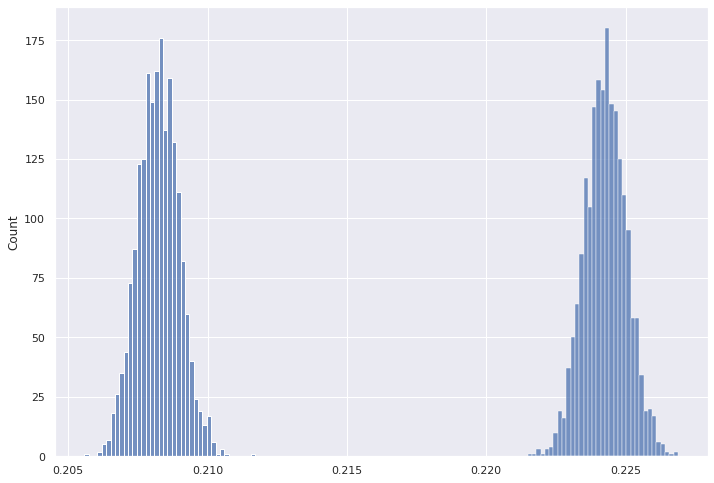

In [43]:
sns.histplot(ctr1)
sns.histplot(ctr2)

Распределения даже не пересекаются, значит p-value будет равно 0. Это значит, что группы имеют различия.

<AxesSubplot:ylabel='Count'>

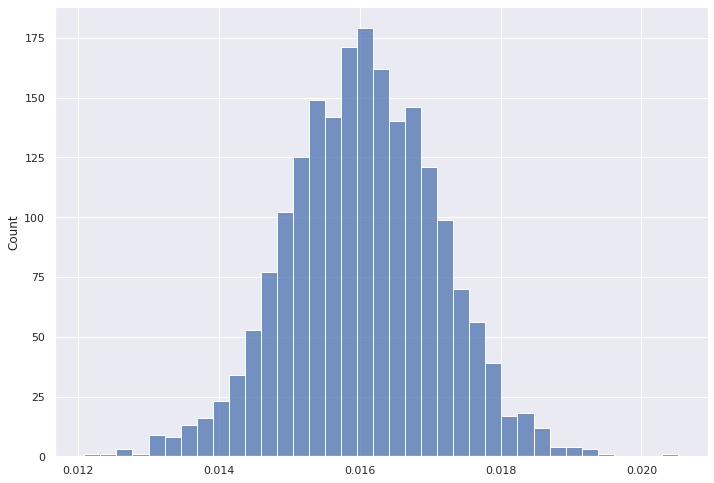

In [44]:
# Разница между глобальными CTR
sns.histplot(ctr2 - ctr1)

Распределение лежит правее нуля

### Бакетное преобразование
 Надо разбить пользователей на n «корзинок» («бакетов»). Нужно гарантировать, что каждый пользователь попадет только в один бакет и пользователи по бакетам будут распределены равномерно. Это можно гарантировать с помощью того же хеширования с солью. 

In [46]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes / views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-04-04' and '2022-04-10'
        and exp_group in (0, 3)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

In [47]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [48]:
df.head()

,exp_group,bucket,bucket_ctr,ctr9
0,0,0,0.207640,0.333333
1,3,0,0.218673,0.340426
2,0,1,0.209715,0.324324
3,3,1,0.223644,0.366667
4,0,2,0.202441,0.333333


In [52]:
# тест Манна-Уитни
stats.mannwhitneyu(df[df['exp_group'] == 0]['bucket_ctr'], 
                   df[df['exp_group'] == 3]['bucket_ctr'], 
                   alternative='two-sided')

MannwhitneyuResult(statistic=45.0, pvalue=1.0099815060146218e-16)

Тест показал, что различия есть

In [60]:
# t-тест
st, p = stats.ttest_ind(df[df['exp_group'] == 0]['bucket_ctr'], 
                   df[df['exp_group'] == 3]['bucket_ctr'], 
                   equal_var=False)

In [61]:
st, p

(-14.755503007460415, 1.2278707215533271e-26)

Тест показал, что различия есть

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

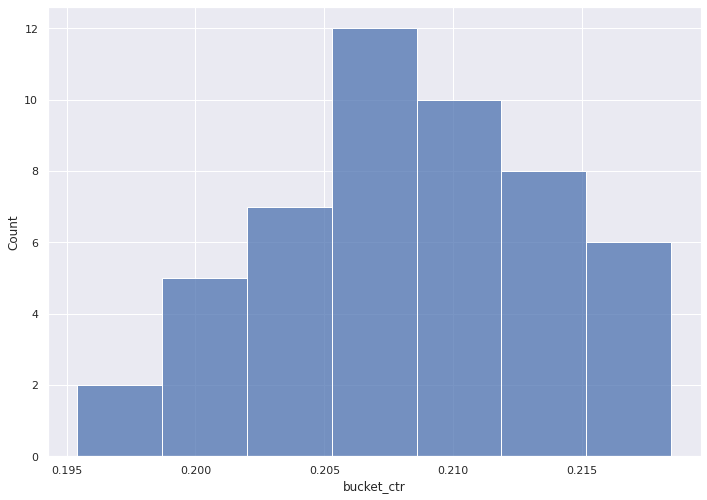

In [54]:
# Распределение бакетного CTR
sns.histplot(df[df.exp_group == 0].bucket_ctr)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

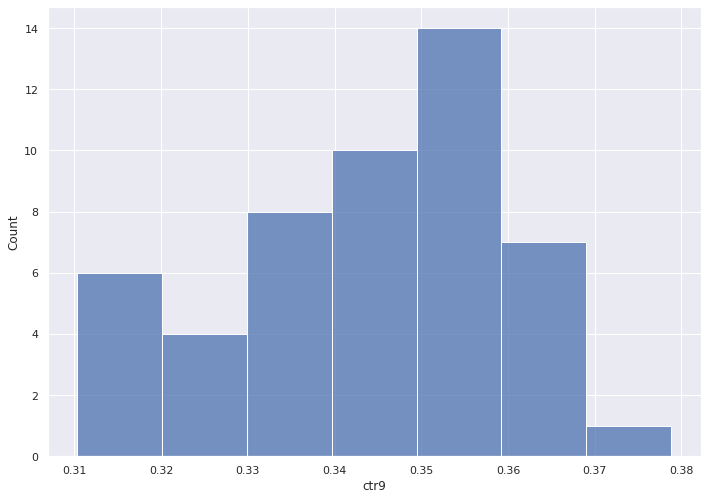

In [56]:
# Распределение бакетного CTR по 90 перцентилю
sns.histplot(df[df['exp_group'] == 3]['ctr9'])

Не очень похоже на нормальное распределение, нужно быть осторожнее с т-тестом